In [112]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd
import seaborn as sns
sns.set()

from importlib.resources import files

DATA_DIR = files("biobank_olink.data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
from itertools import chain

results = [json.load(p.open()) for p in (DATA_DIR / "results").iterdir() if
           p.name.startswith('two_extremes_exp')]
results = pd.DataFrame(chain.from_iterable(results))
results

,auc_score,learning_rate,n_estimators,max_depth,min_child_weight,subsample,colsample_bytree,colsample_bylevel,colsample_bynode,gamma,...,outer_splits,inner_splits,n_trials,optuna_n_workers,num_gpus,seed,study_name,feat_importance,y_test,y_proba
0,0.800524,0.017620,1881,4,10,0.342886,0.792910,0.684067,0.635783,1.410117,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_remove_corr_ig...,"{'ACY1': 0.0028325922321528196, 'ERBB2': 0.002...",NaN,NaN
1,0.809461,0.034799,2000,3,8,0.713941,0.477220,0.676861,0.484628,3.032847,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_remove_corr_ig...,"{'ERBB2': 0.003207206493243575, 'IL1R2': 0.002...",NaN,NaN
2,0.802329,0.045651,1726,2,3,0.410506,0.702073,0.981524,0.539808,3.838577,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_remove_corr_ig...,"{'ERBB2': 0.00311840046197176, 'ACY1': 0.00279...",NaN,NaN
3,0.792024,0.034820,1723,3,18,0.683438,0.641167,0.262548,0.805813,1.517563,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_remove_corr_ig...,"{'ERBB2': 0.003437293926253915, 'ERBB3': 0.003...",NaN,NaN
4,0.810232,0.038071,1625,3,18,0.621316,0.415702,0.912701,0.547059,1.110242,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_remove_corr_ig...,"{'ERBB2': 0.0035992837511003017, 'ACY1': 0.003...",NaN,NaN
5,0.802212,0.040004,1931,2,14,0.456802,0.792341,0.573024,0.599646,6.876193,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_ignore_corr_dr...,"{'ACY1': 0.0034462399780750275, 'MME': 0.00310...",NaN,NaN
6,0.800046,0.016846,1939,5,18,0.460557,0.952461,0.912215,0.237589,0.026845,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_ignore_corr_dr...,"{'REN': 0.002530044876039028, 'ERBB2': 0.00237...",NaN,NaN
7,0.789975,0.022747,2000,3,8,0.435023,0.796488,0.905048,0.372439,1.319777,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_ignore_corr_dr...,"{'ERBB2': 0.0023274747654795647, 'GGT1': 0.002...",NaN,NaN
8,0.797427,0.037556,1674,2,14,0.558305,0.762818,0.885351,0.449748,2.433559,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_ignore_corr_dr...,"{'IL1R2': 0.004872176796197891, 'ERBB2': 0.004...",NaN,NaN
9,0.798845,0.125097,1837,1,19,0.675048,0.761054,0.616416,0.664589,0.639475,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_ignore_corr_dr...,"{'ERBB3': 0.0184722188860178, 'CPM': 0.0151787...",NaN,NaN


In [114]:
results.groupby(["target", "nan_handling", "corr_handling"]).auc_score.mean()

target  nan_handling  corr_handling
DBP     remove        drop             0.792996
SBP     ignore        drop             0.797701
        remove        drop             0.800344
                      ignore           0.802914
Name: auc_score, dtype: float64

In [115]:
one_case = results.loc[(results.target == "SBP") & (results.nan_handling == "remove") & (
            results.corr_handling == "drop")]
one_case

,auc_score,learning_rate,n_estimators,max_depth,min_child_weight,subsample,colsample_bytree,colsample_bylevel,colsample_bynode,gamma,...,outer_splits,inner_splits,n_trials,optuna_n_workers,num_gpus,seed,study_name,feat_importance,y_test,y_proba
10,0.810475,0.038578,1811,2,14,0.655374,0.653263,0.529416,0.573659,2.977008,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_remove_corr_dr...,"{'AARSD1': 0.0, 'ABHD14B': 0.00044143025297671...","[True, True, True, False, True, True, False, T...","[0.603756308555603, 0.20809406042099, 0.309371..."
11,0.799644,0.064983,1880,3,16,0.676120,0.786437,0.170428,0.776522,1.482799,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_remove_corr_dr...,"{'AARSD1': 0.0005668420344591141, 'ABHD14B': 0...","[False, True, False, False, True, False, False...","[0.7617473602294922, 0.8622569441795349, 0.855..."
12,0.804242,0.029488,1966,11,19,0.528021,0.979845,0.679626,0.549552,1.736007,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_remove_corr_dr...,"{'AARSD1': 0.0006902142195031047, 'ABHD14B': 0...","[False, False, False, True, False, True, True,...","[0.2909764051437378, 0.8461684584617615, 0.142..."
13,0.801090,0.022919,1895,5,14,0.459466,0.849621,0.813075,0.303150,2.724777,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_remove_corr_dr...,"{'AARSD1': 0.0008767463150434196, 'ABHD14B': 0...","[True, False, True, True, True, False, False, ...","[0.610845685005188, 0.38528838753700256, 0.384..."
14,0.786270,0.021689,1995,5,18,0.564691,0.867811,0.455351,0.376245,2.253626,...,5,5,100,1,8,42,two_extremes_exp_sbp_th0.35_nan_remove_corr_dr...,"{'AARSD1': 0.0007451536366716027, 'ABHD14B': 0...","[False, True, True, True, False, True, False, ...","[0.4162340462207794, 0.9906628131866455, 0.952..."


In [116]:
one_case.auc_score.mean()

0.8003440068173724

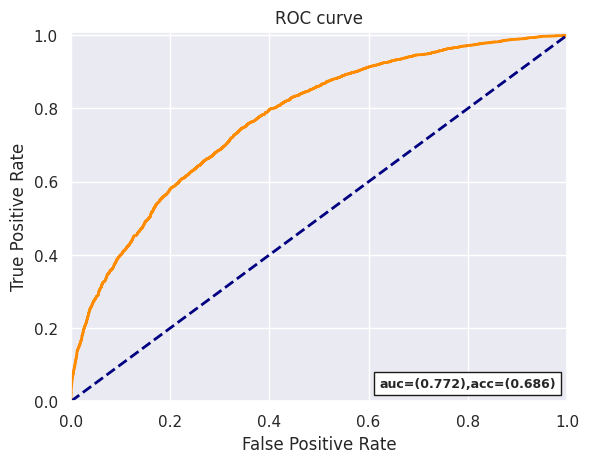

In [124]:
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import roc_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

y_test, y_prob = one_case["y_test"].values, one_case["y_proba"].values
y_test, y_prob = np.concatenate(y_test), np.concatenate(y_prob)

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
acc_score = accuracy_score(y_test, y_prob > 0.5)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0, 1.0])
plt.ylim([0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
ax = plt.gca()

anc = AnchoredText(f"auc=({roc_auc:.3f}),acc=({acc_score:.3f})",
                   loc="lower right", frameon=True, prop=dict(size=9, fontweight="bold"))
ax.add_artist(anc)

plt.show()

In [111]:
feat_imps = one_case.feat_importance
feat_imps = pd.DataFrame(list(feat_imps.values)).T.sort_values(0, ascending=False)
feat_imps.rank(ascending=False)

,0,1,2,3,4
ERBB3,1.0,9.0,14.0,277.0,60.0
IL1R2,2.0,33.0,261.0,6.0,443.0
APOM,3.0,60.0,35.0,9.0,11.0
GGT1,4.0,18.0,103.0,20.0,2.0
LAMP2,5.0,37.0,60.0,32.0,19.0
...,...,...,...,...,...
COL9A1,1195.0,1335.0,627.0,1116.0,1269.0
PRSS2,1195.0,564.0,1038.0,1245.0,749.0
COX5B,1195.0,879.0,598.0,659.0,437.0
CPA1,1195.0,1299.0,928.0,875.0,1052.0


In [108]:
feat_imps.mean(axis=1).sort_values(ascending=False)

REN      0.002476
ACY1     0.002390
ERBB2    0.002351
ERBB3    0.002260
GGT1     0.002127
           ...   
SELP     0.000412
PRDX5    0.000399
CA13     0.000363
BIN2     0.000354
ENO2     0.000325
Length: 1354, dtype: float64

In [ ]:
# check whether any of the top features correlates with those we removed